## Project 06: Multimodal (image and text) representation learning in healthcare   to combine text and image data in the medical domain




### Phase 2: EDA and Feature Extraction

#### Deliverables/tasks: 
* A PDF document with all key observations and analysis and the Python notebook with detailed code (with comments).
* Recommend writeup: 8-10 pages and Python notebook.
* You will be evaluated based on the rigor, breadth and depth of your analysis and the quality of observations you have made. More insightful the observations, the better.
* Data-set level and output-variable analysis
* Univariate Feature Analysis. What options do you have? Why did you pick * * * * specific feature analysis strategies? What are the pros and cons of the method(s) we employed?
* ultivariate Feature analysis. What options do you have? Why did you pick * * * specific feature analysis strategies? What are the pros and cons of the method(s) we employed?
* How would you encode each feature? What options do you have? Why did you pick * specific feature encoding strategies? What are the pros and cons of the method(s) we employed? 
* Advanced Feature encoding mechanisms based on domain-specific transforms, Matrix Factorization, Deep-Learning, data-specific transforms that you would like to apply. What options do you have? Why did you pick specific feature encoding strategies? What are the pros and cons of the method(s) we employed? 
High-dimensional data visualization. What options do you have? Which of them are relevant to your problem? What are the pros and cons of approaches you choose?
* For each of the above analysis and plots, please provide a point-wise summary of key observations at the end.


## Exploratory Data Analysis

### Connecting to google drive

### Importing the required libraries

In [1]:
import gdown
import tarfile
import os
import time
import random
import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import seaborn as sns
import numpy as np
import regex as re
import cv2
from skimage.transform import resize
from wordcloud import WordCloud, STOPWORDS  #for plotting wordcloud


### Loading dataset

### Extracting the image and reports to folders

### Understanding the data

In [2]:
image_path, image_dirs, image_files = next(os.walk(os.getcwd()+"/images"))
print("Total number of images after extraction : " ,len(image_files)-1 )

report_path, report_dirs, report_files = next(os.walk(os.getcwd()+"/reports/ecgen-radiology"))
print("Total number of reports after extraction : " ,len(report_files))

Total number of images after extraction :  7469
Total number of reports after extraction :  3955


### Observations :

*   There are 7470 X-Ray images and one .db file and 3955 reports in total.
*   So a few reports have more than one image associated with them



### Analysing the folder sizes

In [3]:
#https://www.codespeedy.com/get-the-size-of-a-folder-in-python/
def get_folder_size(folder_path):  
    total_folder_size = 0   
    #use the walk() method to navigate through directory tree
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for i in filenames:            
            #use join to concatenate all the components of path
            f = os.path.join(dirpath, i)           
            #use getsize to generate size in bytes and add it to the total size
            total_folder_size += os.path.getsize(f)
    return total_folder_size

print("The size of the images is {} MB ".format(get_folder_size(os.getcwd()+'/images')/1000000))
print("The size of the reports is {} MB ".format(get_folder_size(os.getcwd()+'/reports')/1000000))

The size of the images is 1369.556065 MB 
The size of the reports is 20.785154 MB 


### Checking the sizes of the image

In [4]:
width_list = []
height_list = []
for dirpath, dirnames, filenames in os.walk(os.getcwd()+'/images'):
  for i in filenames:
     f = os.path.join(dirpath, i)
     if(f == os.getcwd()+'/images/Thumbs.db' ):
       continue
     im = Image.open(f)
     width, height = im.size
     width_list.append(width)
     height_list.append(height)
print("# of Unique widths in the image sizes : {} and Unique width is {} px".format(len(set(width_list)),list(set(width_list))[0]))
print("# of Unique heights in the image sizes : ",len(set(height_list)))
print('Unique heights range from {} px and {} px'.format(list(sorted(set(height_list)))[0],list(sorted(set(height_list)))[-1]))

# of Unique widths in the image sizes : 1 and Unique width is 512 px
# of Unique heights in the image sizes :  304
Unique heights range from 362 px and 873 px


#### Observations :

*  All the images have same width of 512 px.
*  But height is varying from 362 p to 873 px.
*  The images have to be re-sized according to i/p size of pre-trained image model input size.



### Display a random XML report

In [5]:
for d,j,reports in os.walk('/content/reports/ecgen-radiology'):
  with open("/content/reports/ecgen-radiology/"+ random.choice(reports), 'r') as f:
    print(f.read())

#### Obervations :

The fields which seem to be important and userful are :

*   pmcid : Patient id 
*   COMPARISION
*   INDICATION 
*   FINDINGS  (Target Variable)
*   IMPRESSIONS
*   Image id (count of "parentImage id" to track the number of images per report)

### Sample Report

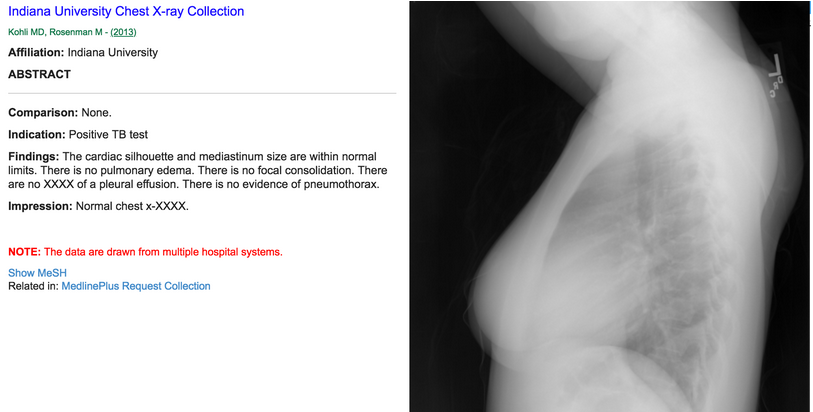

This is  a sample report. The report is stored in xml format. We will extract findings part of the report. as we are considering the findings as captions to extract.

<h3> 3.2.4 Extracting information from XML & Creating Dataframe <h3>

In [6]:
images = []
patient_ids = []
img_findings = []
for filename in tqdm(os.listdir(os.getcwd()+'/reports/ecgen-radiology')):
    if filename.endswith(".xml"):
        f = os.path.join(os.getcwd()+'/reports/ecgen-radiology',filename)     
        tree = ET.parse(f)
        root = tree.getroot()
        for child in root:
            if child.tag == 'uId':
              patient = child.attrib['id']
            if child.tag == 'MedlineCitation':
                for attr in child:
                    if attr.tag == 'Article':
                        for i in attr:
                            if i.tag == 'Abstract':
                                for name in i:
                                    if name.get('Label') == 'FINDINGS':
                                        findings=name.text                                      
        for p_image in root.findall('parentImage'):
            patient_ids.append(patient)          
            images.append(p_image.get('id'))
            img_findings.append(findings)

  0%|          | 0/3955 [00:00<?, ?it/s]

In [7]:
findings_dataset = pd.DataFrame()
findings_dataset['patient_id'] = patient_ids
findings_dataset['image_path'] = images
findings_dataset['image_path'] = '/content/images/'+findings_dataset['image_path']+'.png'
findings_dataset['findings'] = img_findings
findings_dataset.tail()

,patient_id,image_path,findings
7465,CXR998,/content/images/CXR998_IM-2479-1001.png,Cardiomediastinal silhouette demonstrates norm...
7466,CXR998,/content/images/CXR998_IM-2479-2001.png,Cardiomediastinal silhouette demonstrates norm...
7467,CXR999,/content/images/CXR999_IM-2480-1001.png,Lungs are clear bilaterally. There is no focal...
7468,CXR999,/content/images/CXR999_IM-2480-2001.png,Lungs are clear bilaterally. There is no focal...
7469,CXR999,/content/images/CXR999_IM-2480-3001.png,Lungs are clear bilaterally. There is no focal...


In [8]:
findings_dataset.isnull().sum()

patient_id      0
image_path      0
findings      997
dtype: int64

### Number of images per patient

In [9]:
images_count_per_patient  = findings_dataset.groupby(['patient_id']).size().reset_index(name='Imagesperpatient')
images_count_per_patient

,patient_id,Imagesperpatient
0,CXR1,2
1,CXR10,2
2,CXR100,2
3,CXR1000,3
4,CXR1001,2
...,...,...
3846,CXR995,2
3847,CXR996,2
3848,CXR997,2
3849,CXR998,2


E:\Users\Asus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Images per patient ')

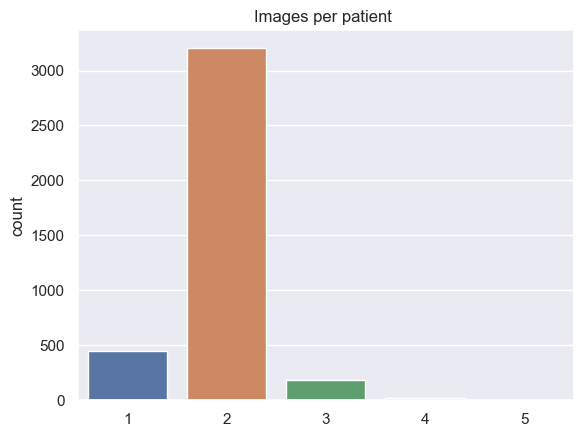

In [10]:
counts=list(images_count_per_patient['Imagesperpatient'].values)
sns.set_theme(style="darkgrid")
sns.countplot(counts)
plt.title("Images per patient ")

### Patient counts with number images

In [11]:
for imagecount in sorted(list(Counter(counts).keys())):
  print('Patients with {} images : {}'.format(imagecount,Counter(counts)[imagecount]))

Patients with 1 images : 446
Patients with 2 images : 3208
Patients with 3 images : 181
Patients with 4 images : 15
Patients with 5 images : 1


### Observations:

*   In total there are 3851 unique patients
      * Patients with 1 images : 446
      * Patients with 2 images : 3208
      * Patients with 3 images : 181
      * Patients with 4 images : 15
      * Patients with 5 images : 1
*   So to capture most of the information we give input of two images to the model. as below

      * If the patient has one X-ray associated with report we replicate same image twice as image1 and image2
      * If the patient has two X-rays associated with the report we replicate first image as  image1 and second as image2
      * If the patient has more than two  X-rays associated with the report we randomly chose 2 X-rays as image1 and image2






In [12]:
image_findings_dataset = pd.DataFrame(columns=['patient_id','image1','image2','findings'])
i = 0
j = 0
while i<findings_dataset.shape[0]:
  pt_id = findings_dataset[i:i+1]['patient_id'].values[0]
  #print(pt_id)
  image_counts = images_count_per_patient[images_count_per_patient.patient_id == pt_id]['Imagesperpatient'].values[0]
  if image_counts==1:
    image_findings_dataset.at[j,'patient_id'] = pt_id
    image_findings_dataset.at[j,'image1'] = findings_dataset[findings_dataset.patient_id == pt_id]['image_path'].values[0]
    image_findings_dataset.at[j,'image2'] = findings_dataset[findings_dataset.patient_id == pt_id]['image_path'].values[0]
    image_findings_dataset.at[j,'findings'] = findings_dataset[findings_dataset.patient_id == pt_id]['findings'].values[0]

  elif image_counts==2:
    image_findings_dataset.at[j,'patient_id'] = pt_id
    image_findings_dataset.at[j,'image1'] = findings_dataset[findings_dataset.patient_id == pt_id]['image_path'].values[0]
    image_findings_dataset.at[j,'image2'] = findings_dataset[findings_dataset.patient_id == pt_id]['image_path'].values[1]
    image_findings_dataset.at[j,'findings'] = findings_dataset[findings_dataset.patient_id == pt_id]['findings'].values[0]

  else:
    choices = np.random.choice(image_counts,2)
    image_findings_dataset.at[j,'patient_id'] = pt_id
    image_findings_dataset.at[j,'image1'] = findings_dataset[findings_dataset.patient_id == pt_id]['image_path'].values[choices[0]]
    image_findings_dataset.at[j,'image2'] = findings_dataset[findings_dataset.patient_id == pt_id]['image_path'].values[choices[1]]
    image_findings_dataset.at[j,'findings'] = findings_dataset[findings_dataset.patient_id == pt_id]['findings'].values[0]
  
  i = i + image_counts
  j = j + 1

image_findings_dataset.head()

,patient_id,image1,image2,findings
0,CXR1,/content/images/CXR1_1_IM-0001-3001.png,/content/images/CXR1_1_IM-0001-4001.png,The cardiac silhouette and mediastinum size ar...
1,CXR10,/content/images/CXR10_IM-0002-1001.png,/content/images/CXR10_IM-0002-2001.png,The cardiomediastinal silhouette is within nor...
2,CXR100,/content/images/CXR100_IM-0002-1001.png,/content/images/CXR100_IM-0002-2001.png,Both lungs are clear and expanded. Heart and m...
3,CXR1000,/content/images/CXR1000_IM-0003-1001.png,/content/images/CXR1000_IM-0003-1001.png,There is XXXX increased opacity within the rig...
4,CXR1001,/content/images/CXR1001_IM-0004-1001.png,/content/images/CXR1001_IM-0004-1002.png,Interstitial markings are diffusely prominent ...


### Analysing and preprocessing findings

In [13]:
print('Null values in image_findings_dataset')
print(image_findings_dataset.isnull().sum())
print('Percentage of null values in findings : ',(image_findings_dataset.findings.isnull().sum()/len(image_findings_dataset))*100)


Null values in image_findings_dataset
patient_id      0
image1          0
image2          0
findings      514
dtype: int64
Percentage of null values in findings :  13.347182549987016


##### Droping the records where findings is null

In [14]:
image_findings_dataset = image_findings_dataset.dropna(axis=0)
image_findings_dataset.isnull().sum()

patient_id    0
image1        0
image2        0
findings      0
dtype: int64

### Observations :

*   There are around 13 % null values(None) in findings column.
*   Will drop the rows with null value in findings column as we cannot fill the null values.





#### Converting findings to lower case

In [15]:
image_findings_dataset['findings'] = image_findings_dataset.loc[:,('findings')].str.lower()

#### Expanding contractions in the text

In [16]:
#https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
def decontracted(row):
  # specific
  row = str(row)
  row = re.sub(r"won\'t", "will not", row)
  row = re.sub(r"can\'t", "can not", row)
  # general
  row = re.sub(r"n\'t", " not", row)
  row = re.sub(r"\'re", " are", row)
  row = re.sub(r"\'s", " is", row)
  row = re.sub(r"\'d", " would", row)
  row = re.sub(r"\'ll", " will", row)
  row = re.sub(r"\'t", " not", row)
  row = re.sub(r"\'ve", " have", row)
  row = re.sub(r"\'m", " am", row)
  row = re.sub('xxxx','',row) #occurs many times in text may be private information which isn't useful
  return str(row)

image_findings_dataset['findings']= image_findings_dataset['findings'].apply(decontracted)
image_findings_dataset.head()

,patient_id,image1,image2,findings
0,CXR1,/content/images/CXR1_1_IM-0001-3001.png,/content/images/CXR1_1_IM-0001-4001.png,the cardiac silhouette and mediastinum size ar...
1,CXR10,/content/images/CXR10_IM-0002-1001.png,/content/images/CXR10_IM-0002-2001.png,the cardiomediastinal silhouette is within nor...
2,CXR100,/content/images/CXR100_IM-0002-1001.png,/content/images/CXR100_IM-0002-2001.png,both lungs are clear and expanded. heart and m...
3,CXR1000,/content/images/CXR1000_IM-0003-1001.png,/content/images/CXR1000_IM-0003-1001.png,there is increased opacity within the right u...
4,CXR1001,/content/images/CXR1001_IM-0004-1001.png,/content/images/CXR1001_IM-0004-1002.png,interstitial markings are diffusely prominent ...


#### Removing Numbers and junk words like 'xxxx' and 'xxx'

In [17]:
def preprocessing(row):
  row = str(row)
  row = re.sub(r'xx*','',row) # Removing XXXX
  row = re.sub(r'\d','',row) # Removing numbers 
  temp = ""
  for i in row.split(" "): #Removing 2 letter words
    if i!= 'no' or i!='ct':
      temp = temp + ' ' + i
  temp = re.sub(' {2,}', ' ',temp) #Replacing double space with single space
  temp = re.sub(r'\.+', ".", temp) #Replacing double . with single .
  temp = temp.lstrip() #Removing space at the beginning
  temp = temp.rstrip() #Removing space at the end
  return temp

image_findings_dataset['findings']= image_findings_dataset['findings'].apply(preprocessing)


In [18]:
image_findings_dataset.head()

,patient_id,image1,image2,findings
0,CXR1,/content/images/CXR1_1_IM-0001-3001.png,/content/images/CXR1_1_IM-0001-4001.png,the cardiac silhouette and mediastinum size ar...
1,CXR10,/content/images/CXR10_IM-0002-1001.png,/content/images/CXR10_IM-0002-2001.png,the cardiomediastinal silhouette is within nor...
2,CXR100,/content/images/CXR100_IM-0002-1001.png,/content/images/CXR100_IM-0002-2001.png,both lungs are clear and epanded. heart and me...
3,CXR1000,/content/images/CXR1000_IM-0003-1001.png,/content/images/CXR1000_IM-0003-1001.png,there is increased opacity within the right up...
4,CXR1001,/content/images/CXR1001_IM-0004-1001.png,/content/images/CXR1001_IM-0004-1002.png,interstitial markings are diffusely prominent ...


#### Understanding the words statistics of findings 

In [19]:
def words_count(row):
  """Counts number of words in given sentence"""
  row = str(row)
  return len(row.split(" "))
num_words = pd.DataFrame(columns=['findings'])
num_words['findings']= image_findings_dataset['findings'].apply(words_count)
num_words.describe(percentiles = [0.25,0.75,0.95,0.99])

,findings
count,3337.000000
mean,30.830087
std,14.078474
min,7.000000
25%,21.000000
50%,29.000000
75%,37.000000
95%,57.000000
99%,76.000000
max,167.000000


#### Observations :

*   The maximum length of an Findings is 167 words 
*   mean Findings are  30 words 
*   75th percentile is 37 words 
*   99th percentile is 76






### understanding wordcloud for findings

C:\Users\Asus\AppData\Local\Temp\ipykernel_5284\3096258949.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  temp = image_findings_dataset.loc[:,'findings'].str.replace(".","").copy() #removing all fullstops and storing the result in a temp variable


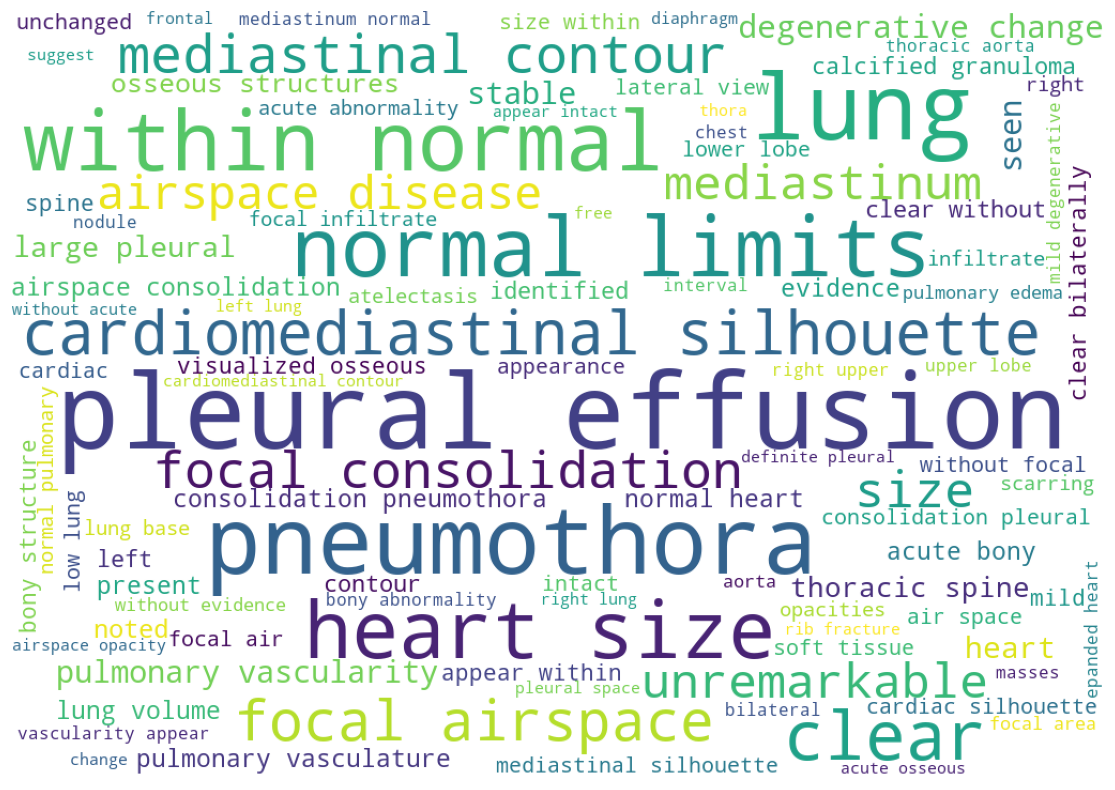

In [20]:
#getting wordclouds
#https://www.geeksforgeeks.org/generating-word-cloud-python/
temp = image_findings_dataset.loc[:,'findings'].str.replace(".","").copy() #removing all fullstops and storing the result in a temp variable
words = ""
for i in temp.values:
  k = i.split()
  words+= " ".join(k) + " "
word = words.strip()
wc = WordCloud(width = 1024, height = 720, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 15,).generate(words) 

del k,words,temp
plt.figure(figsize = (20,10))
plt.imshow(wc)
plt.axis("off")
plt.show()

#### Viewing some random X-Rays and there corresponding findings

<h3> 3.2.7 Adding start and end tokens <h3>

In [21]:
#Adding start and End tokens
image_findings_dataset['findings_total'] = '<start>' + ' ' + image_findings_dataset.findings.astype(str) + ' ' +'<end>'
image_findings_dataset['decoder_ip'] = '<start>' + ' ' + image_findings_dataset.findings.astype(str)  #Decoder input
image_findings_dataset['decoder_op'] = image_findings_dataset.findings.astype(str) + ' ' +'<end>'     #Decoder output
image_findings_dataset.head()

,patient_id,image1,image2,findings,findings_total,decoder_ip,decoder_op
0,CXR1,/content/images/CXR1_1_IM-0001-3001.png,/content/images/CXR1_1_IM-0001-4001.png,the cardiac silhouette and mediastinum size ar...,<start> the cardiac silhouette and mediastinum...,<start> the cardiac silhouette and mediastinum...,the cardiac silhouette and mediastinum size ar...
1,CXR10,/content/images/CXR10_IM-0002-1001.png,/content/images/CXR10_IM-0002-2001.png,the cardiomediastinal silhouette is within nor...,<start> the cardiomediastinal silhouette is wi...,<start> the cardiomediastinal silhouette is wi...,the cardiomediastinal silhouette is within nor...
2,CXR100,/content/images/CXR100_IM-0002-1001.png,/content/images/CXR100_IM-0002-2001.png,both lungs are clear and epanded. heart and me...,<start> both lungs are clear and epanded. hear...,<start> both lungs are clear and epanded. hear...,both lungs are clear and epanded. heart and me...
3,CXR1000,/content/images/CXR1000_IM-0003-1001.png,/content/images/CXR1000_IM-0003-1001.png,there is increased opacity within the right up...,<start> there is increased opacity within the ...,<start> there is increased opacity within the ...,there is increased opacity within the right up...
4,CXR1001,/content/images/CXR1001_IM-0004-1001.png,/content/images/CXR1001_IM-0004-1002.png,interstitial markings are diffusely prominent ...,<start> interstitial markings are diffusely pr...,<start> interstitial markings are diffusely pr...,interstitial markings are diffusely prominent ...


Dataset to pickle

In [22]:
image_findings_dataset.to_pickle('findings_preprocessed_dataset.pkl') 

Copying pickle to google drive